# Design layer f
- f(z,x)=σ(Wz+Ux+b)
- in practice we do want to incorporate some additional structure in the layer rather than just this generic feedforward model.
$$
f(z, x)=\operatorname{norm}\left(\operatorname{ReLU}\left(z+\operatorname{norm}\left(x+W_2 *\left(\operatorname{norm}\left(\operatorname{ReLU}\left(W_1 * z\right)\right)\right)\right)\right)\right)
$$
- z是要迭代求的fix point
- x是轻微修改后的输入
-  For simplicity we simply initialize all weights in out layer as random samples from N(0,0.01), though the preise ideal scaling laws for the variance terms are still not well understood (though a reasonably wide range of this smaller variance initiailzation works well).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNetLayer(nn.Module):
    def __init__(self, n_channels, n_inner_channels, kernel_size=3, num_groups=8):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, n_inner_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.conv2 = nn.Conv2d(n_inner_channels, n_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.norm1 = nn.GroupNorm(num_groups, n_inner_channels)
        self.norm2 = nn.GroupNorm(num_groups, n_channels)
        self.norm3 = nn.GroupNorm(num_groups, n_channels)
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        
    def forward(self, z, x):
        y = self.norm1(F.relu(self.conv1(z)))
        return self.norm3(F.relu(z + self.norm2(x + self.conv2(y))))
    # we will choose n_channels in the above layer to be smaller than n_inner_channels

# Implementation of the forward pass


In [3]:
def anderson(f, x0, m=5, lam=1e-4, max_iter=50, tol=1e-2, beta = 1.0):
    """ Anderson acceleration for fixed point iteration. """
    bsz, d, H, W = x0.shape
    X = torch.zeros(bsz, m, d*H*W, dtype=x0.dtype, device=x0.device)
    F = torch.zeros(bsz, m, d*H*W, dtype=x0.dtype, device=x0.device)
    X[:,0], F[:,0] = x0.view(bsz, -1), f(x0).view(bsz, -1)
    X[:,1], F[:,1] = F[:,0], f(F[:,0].view_as(x0)).view(bsz, -1)
    
    H = torch.zeros(bsz, m+1, m+1, dtype=x0.dtype, device=x0.device)
    H[:,0,1:] = H[:,1:,0] = 1
    y = torch.zeros(bsz, m+1, 1, dtype=x0.dtype, device=x0.device)
    y[:,0] = 1
    
    res = []
    for k in range(2, max_iter):
        n = min(k, m)
        G = F[:,:n]-X[:,:n]
        H[:,1:n+1,1:n+1] = torch.bmm(G,G.transpose(1,2)) + lam*torch.eye(n, dtype=x0.dtype,device=x0.device)[None]
        xx = torch.linalg.solve(H[:,:n+1,:n+1], y[:,:n+1])
        # print(xx.shape)
        alpha = torch.linalg.solve(H[:,:n+1,:n+1], y[:,:n+1])[:, 1:n+1, 0]   # (bsz x n)
        
        X[:,k%m] = beta * (alpha[:,None] @ F[:,:n])[:,0] + (1-beta)*(alpha[:,None] @ X[:,:n])[:,0]
        F[:,k%m] = f(X[:,k%m].view_as(x0)).view(bsz, -1)
        res.append((F[:,k%m] - X[:,k%m]).norm().item()/(1e-5 + F[:,k%m].norm().item()))
        if (res[-1] < tol):
            break
    return X[:,k%m].view_as(x0), res

Text(0, 0.5, 'Relative residual')

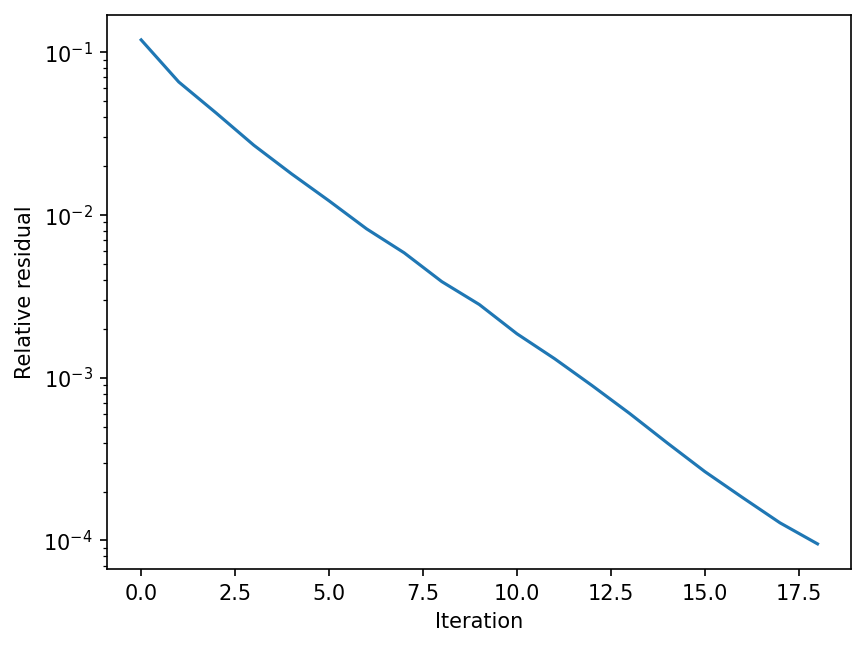

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

X = torch.randn(10,64,32,32)
f = ResNetLayer(64,128)
Z, res = anderson(lambda Z : f(Z,X), torch.zeros_like(X), tol=1e-4, beta=1.0)
plt.figure(dpi=150)
plt.semilogy(res)
plt.xlabel("Iteration")
plt.ylabel("Relative residual")

Text(0, 0.5, 'Relative residual')

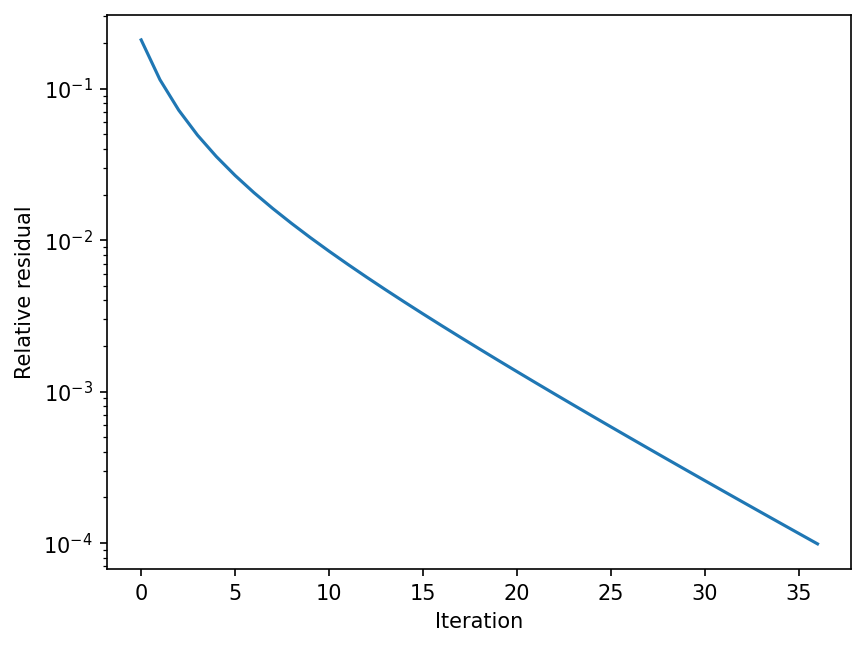

In [5]:
def forward_iteration(f, x0, max_iter=50, tol=1e-2):
    f0 = f(x0)
    res = []
    for k in range(max_iter):
        x = f0
        f0 = f(x)
        res.append((f0 - x).norm().item() / (1e-5 + f0.norm().item()))
        if (res[-1] < tol):
            break
    return f0, res

Z, res = forward_iteration(lambda Z : f(Z,X), torch.zeros_like(X), tol=1e-4)
plt.figure(dpi=150)
plt.semilogy(res)
plt.xlabel("Iteration")
plt.ylabel("Relative residual")

# Backward Pass

In [6]:
import torch.autograd as autograd

class DEQFixedPoint(nn.Module):
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        self.f = f
        self.solver = solver
        self.kwargs = kwargs
        
    def forward(self, x):
        # compute forward pass and re-engage autograd tape
        print(f'shape of x: {x.shape}')
        with torch.no_grad():
            z, self.forward_res = self.solver(lambda z : self.f(z, x), torch.zeros_like(x), **self.kwargs)
        z = self.f(z,x)
        
        # set up Jacobian vector product (without additional forward calls)
        z0 = z.clone().detach().requires_grad_()
        f0 = self.f(z0,x)
        def backward_hook(grad):
            g, self.backward_res = self.solver(lambda y : autograd.grad(f0, z0, y, retain_graph=True)[0] + grad,
                                               grad, **self.kwargs)
            return g
                
        z.register_hook(backward_hook)
        return z

In [7]:
from torch.autograd import gradcheck
# run a very small network with double precision, iterating to high precision
f = ResNetLayer(2,2, num_groups=2).double()
deq = DEQFixedPoint(f, anderson, tol=1e-10, max_iter=500).double()
gradcheck(deq, torch.randn(1,2,3,3).double().requires_grad_(), eps=1e-5, atol=1e-3, check_undefined_grad=False)

shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
shape of x: torch.Size([1, 2, 3, 3])
s

KeyboardInterrupt: 

In [8]:
f = ResNetLayer(64,128)
deq = DEQFixedPoint(f, anderson, tol=1e-4, max_iter=100, beta=2.0)
X = torch.randn(10,64,32,32)
out = deq(X)
(out*torch.randn_like(out)).sum().backward()

shape of x: torch.Size([10, 64, 32, 32])


Text(0, 0.5, 'Residual')

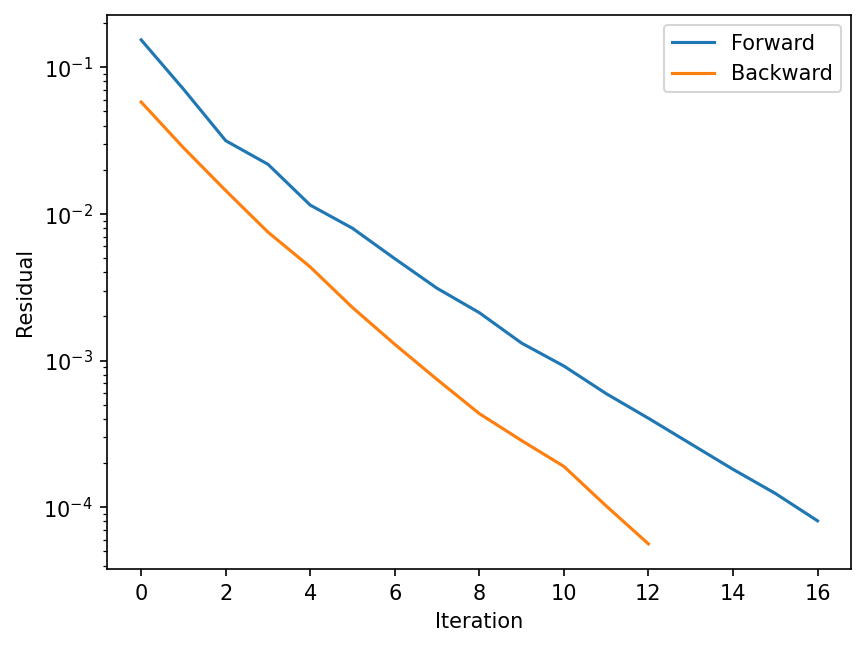

In [9]:
plt.figure(dpi=150)
plt.semilogy(deq.forward_res)
plt.semilogy(deq.backward_res)
plt.legend(['Forward', 'Backward'])
plt.xlabel("Iteration")
plt.ylabel("Residual")

# DEQ on CIFAR

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)
chan = 48
f = ResNetLayer(chan, 64, kernel_size=3)
model = nn.Sequential(nn.Conv2d(3,chan, kernel_size=3, bias=True, padding=1),
                      nn.BatchNorm2d(chan),
                      DEQFixedPoint(f, anderson, tol=1e-2, max_iter=25, m=5),
                      nn.BatchNorm2d(chan),
                      nn.AvgPool2d(8,8),
                      nn.Flatten(),
                      nn.Linear(chan*4*4,10)).to(device)

In [11]:
# CIFAR10 data loader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

cifar10_train = datasets.CIFAR10(".", train=True, download=True, transform=transforms.ToTensor())
cifar10_test = datasets.CIFAR10(".", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(cifar10_train, batch_size = 100, shuffle=True, num_workers=8)
test_loader = DataLoader(cifar10_test, batch_size = 100, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
# standard training or evaluation loop
def epoch(loader, model, opt=None, lr_scheduler=None):
    total_loss, total_err = 0.,0.
    model.eval() if opt is None else model.train()
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
            lr_scheduler.step()
                
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]

    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [13]:
import torch.optim as optim
opt = optim.Adam(model.parameters(), lr=1e-3)
print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

max_epochs = 50
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*len(train_loader), eta_min=1e-6)

for i in range(50):
    print(epoch(train_loader, model, opt, scheduler))
    print(epoch(test_loader, model)) 

# Parmeters:  64842
shape of x: torch.Size([100, 48, 32, 32])
shape of x: torch.Size([100, 48, 32, 32])
shape of x: torch.Size([100, 48, 32, 32])
shape of x: torch.Size([100, 48, 32, 32])
shape of x: torch.Size([100, 48, 32, 32])
shape of x: torch.Size([100, 48, 32, 32])
shape of x: torch.Size([100, 48, 32, 32])
shape of x: torch.Size([100, 48, 32, 32])
shape of x: torch.Size([100, 48, 32, 32])
shape of x: torch.Size([100, 48, 32, 32])


KeyboardInterrupt: 